In [2]:
import pandas as pd 
import numpy as np
import random
import os 
import re
import time
import math
import argparse
import pymysql
import json
import torch
import pickle
import matplotlib.pyplot as plt
from torch import nn
from sklearn.utils import shuffle 
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification
from torch.utils.data import TensorDataset
from attrdict import AttrDict
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import BertConfig, BertTokenizer, BertModel
from transformers.optimization import get_cosine_schedule_with_warmup

In [ ]:
data_path = "/home/lamda_00/Depression_paper/data/"
model_path = "/home/lamda_00/Depression_paper/model/"
ckpt_path = "/home/lamda_00/Depression_paper/ckpt/"
config_path = "/home/lamda_00/Depression_paper/config/"
log_path = "/home/lamda_00/Depression_paper/log/"
config_file = "bert-base.json"

In [6]:
class BertDataset(Dataset):
    def __init__(self, data_file):
        self.data = data_file
    
    def __len__(self):
        return len(self.data.label)
    
    def reset_index(self):
        self.data.reset_index(inplace=True, drop=True)
    
    def __getitem__(self, idx):
        '''
        return text, label
        '''
        self.reset_index()
        text = self.data.text[idx]
        label = self.data.label[idx]
        return text, label

In [5]:
class BertProcessor():
    def __init__(self, config, training_config, tokenizer, truncation=True):
        self.tokenizer = tokenizer 
        self.max_len = config.max_position_embeddings
        self.pad = training_config.pad
        self.batch_size = training_config.train_batch_size
        self.truncation = truncation
    
    def convert_data(self, data_file):
        context2 = None    # single sentence classification
        batch_encoding = self.tokenizer.batch_encode_plus(
            [(data_file[idx][0], context2) for idx in range(len(data_file))],   # text, 
            max_length = self.max_len,
            padding = self.pad,
            truncation = self.truncation
        )
        
        features = []
        for i in range(len(data_file)):
            inputs = {k: batch_encoding[k][i] for k in batch_encoding}
            try:
                inputs['label'] = data_file[i][1] 
            except:
                # print('input label 오류')
                inputs['label'] = 0 
            features.append(inputs)
        
        all_input_ids = torch.tensor([f['input_ids'] for f in features], dtype=torch.long)
        all_attention_mask = torch.tensor([f['attention_mask'] for f in features], dtype=torch.long)
        all_token_type_ids = torch.tensor([f['token_type_ids'] for f in features], dtype=torch.long)
        all_labels = torch.tensor([f['label'] for f in features], dtype=torch.long)

        dataset = TensorDataset(all_input_ids, all_attention_mask, all_token_type_ids, all_labels)
        return dataset
    
    def shuffle_data(self, dataset, data_type):
        if data_type == 'train':
            return RandomSampler(dataset)
        elif data_type == 'eval' or data_type == 'test':
            return SequentialSampler(dataset)
        
    def load_data(self, dataset, sampler):
        return DataLoader(dataset, sampler=sampler, batch_size=self.batch_size)

In [320]:
dsm_samp = pd.read_csv(os.path.join(data_path, 'dsm_samp_test.csv'))
dsm_samp.head(3)

,id,text,label
0,10iull,"i attempted suicide twice during this, and as ...",8
1,47ohkk,i just have a feeling of sadness constantly in...,0
2,107968,I think it'd be better to wear several thin cl...,9


In [321]:
len(dsm_samp)

19869

In [322]:
tokenizer = BertTokenizer.from_pretrained(os.path.join(model_path, 'bert-base'), model_max_length=32)
config = BertConfig.from_pretrained(os.path.join(model_path, 'bert-base', 'bert_config.json'), output_hidden_states=True)
model = BertModel.from_pretrained(os.path.join(model_path, 'bert-base'), config=config)

Some weights of the model checkpoint at /home/lamda_00/Depression_paper/model/bert-base were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [323]:
model.to(training_config.device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [325]:
dsm_emb = []

for idx in range(len(dsm_samp)):
    encoded = tokenizer.encode_plus(
        text=dsm_samp.text[idx],  # the sentence to be encoded
        add_special_tokens=True,  # Add [CLS] and [SEP]
        max_length = 64,  # maximum length of a sentence
        pad_to_max_length=True,  # Add [PAD]s
        return_attention_mask = True,  # Generate the attention mask
        return_tensors = 'pt',  # ask the function to return PyTorch tensors
    )
    # print(encoded)
    input_ids = torch.tensor(encoded['input_ids']).to(training_config.device)
    attn_mask = torch.tensor(encoded['attention_mask']).to(training_config.device)
    token_type_ids = torch.tensor(encoded['token_type_ids']).to(training_config.device)
    
    outputs = model(input_ids, attn_mask, token_type_ids)
    hidden_states = outputs[2]
    token_vecs = hidden_states[-2][0]
    sentence_embedding = torch.mean(token_vecs, dim=0)
    dsm_emb.append(list(sentence_embedding.detach().cpu().numpy()))

/tmp/ipykernel_756/1956579816.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(encoded['input_ids']).to(training_config.device)
/tmp/ipykernel_756/1956579816.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attn_mask = torch.tensor(encoded['attention_mask']).to(training_config.device)
/tmp/ipykernel_756/1956579816.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  token_type_ids = torch.tensor(encoded['token_type_ids']).to(training_config.device)


In [326]:
dsm_X = pd.DataFrame(dsm_emb, columns=range(len(dsm_emb[0])))
dsm_X

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.016454,0.563271,-0.496813,0.345756,0.400839,0.188649,0.504662,-0.197936,-0.203617,0.025317,...,0.428514,-0.319562,0.075709,0.315475,-0.372621,0.678657,0.189303,0.238480,-0.160216,-0.023061
1,-0.122629,0.426463,-0.423441,0.077765,0.165790,-0.329307,0.339787,-0.093955,-0.094051,0.315138,...,-0.181132,0.181947,-0.413613,-0.000203,0.416569,0.203936,0.315673,0.749521,0.315290,-0.069359
2,0.261822,0.343505,-0.281173,0.221057,0.620400,0.126615,0.338663,-0.046222,-0.455593,0.651060,...,-0.038790,-0.082706,0.231466,-0.241655,0.054290,0.424557,0.164331,-0.159034,0.068502,0.101330
3,-0.178097,0.223301,-0.105389,-0.302861,0.380108,-0.422100,0.519783,0.038934,0.219266,0.091882,...,0.093612,0.132598,-0.423319,0.125397,0.097488,0.184294,-0.039556,0.235633,0.228259,-0.177116
4,0.135610,0.063718,-0.574391,-0.348930,0.050260,-0.208479,0.171989,-0.204762,-0.350197,0.129007,...,0.152382,0.178549,-0.190995,0.343928,0.050634,0.588908,0.382524,0.151464,0.153371,-0.446083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19864,-0.333170,0.408023,-0.449947,-0.138167,0.233330,0.091061,-0.107439,-0.045309,0.151836,0.157560,...,0.445489,-0.186928,0.165101,0.618284,-0.453380,0.752479,-0.513805,-0.228111,0.125357,0.172782
19865,0.015152,0.417644,0.345164,0.076591,0.534281,-0.636585,0.631634,-0.314855,-0.541757,0.507041,...,-0.150049,-0.097750,-0.039084,0.233294,0.529042,0.055799,0.192759,0.483360,0.230499,0.244408
19866,-0.071034,0.582627,0.005751,-0.017133,0.165195,0.072055,-0.037818,-0.898495,-0.498971,0.089028,...,-0.027509,0.204529,0.054448,0.421728,-0.285850,0.162474,-0.352371,-0.243980,0.260900,0.168299
19867,-0.045093,0.391739,-0.045725,-0.346475,0.295731,-0.319571,0.531489,-0.289734,-0.330513,0.231803,...,-0.170525,-0.014378,-0.067417,0.283588,0.387830,0.219238,0.160082,0.003624,0.262180,-0.524316


In [328]:
dsm_y = dsm_samp.label.tolist()

In [329]:
pca = PCA(n_components=30)
dsm_X = pca.fit_transform(dsm_X)

In [330]:
X_embedded = TSNE(n_components=2).fit_transform(dsm_X)

/home/ubuntu/anaconda3/envs/lamda_base/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ubuntu/anaconda3/envs/lamda_base/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


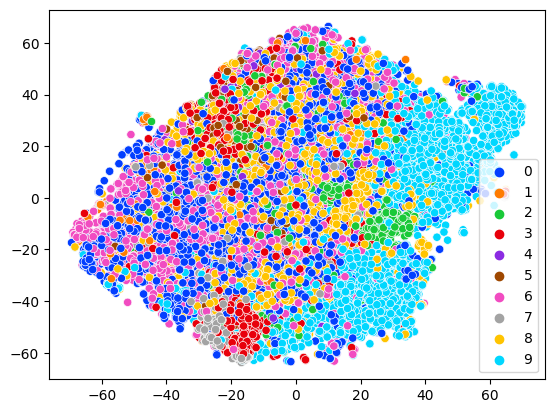

In [331]:
palette = sns.color_palette("bright", 10)
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=dsm_y, legend='full', palette=palette)
plt.show()

#### Trained Model 

In [353]:
tokenizer = BertTokenizer.from_pretrained(os.path.join(model_path, 'bert-base'), model_max_length=32)
config = BertConfig.from_pretrained(os.path.join(model_path, 'bert-base', 'bert_config.json'), num_labels=10, output_hidden_states=True)
model = BertForSequenceClassification.from_pretrained(os.path.join(model_path, 'bert-base'), config=config)

Some weights of the model checkpoint at /home/lamda_00/Depression_paper/model/bert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceCl

In [354]:
config.max_position_embeddings = 32

In [355]:
with open(os.path.join(config_path, 'training_config.json')) as f:
    training_config = AttrDict(json.load(f))

training_config.pad = 'max_length'
training_config.device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
model.to(training_config.device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [356]:
model_name = os.path.join(model_path, 'label_10', 'bert_base', 'bert_dsm_3.pt')

In [357]:
model.load_state_dict(torch.load(model_name))
model.to(training_config.device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [358]:
test_processor = BertProcessor(config, training_config, tokenizer)

In [359]:
text = 'I am depressed'
text2 = 'she is angry to me'

In [360]:
dsm_emb = []

for idx in range(len(dsm_samp)):
    encoded = tokenizer.encode_plus(
        text=dsm_samp.text[idx],  # the sentence to be encoded
        add_special_tokens=True,  # Add [CLS] and [SEP]
        max_length = 64,  # maximum length of a sentence
        pad_to_max_length=True,  # Add [PAD]s
        return_attention_mask = True,  # Generate the attention mask
        return_tensors = 'pt',  # ask the function to return PyTorch tensors
    )
    input_ids = torch.tensor(encoded['input_ids']).to(training_config.device)
    attn_mask = torch.tensor(encoded['attention_mask']).to(training_config.device)
    token_type_ids = torch.tensor(encoded['token_type_ids']).to(training_config.device)
    
    outputs = model(input_ids, attn_mask, token_type_ids)
    hidden_states = outputs[1]
    token_vecs = hidden_states[-2][0]
    sentence_embedding = torch.mean(token_vecs, dim=0)
    dsm_emb.append(list(sentence_embedding.detach().cpu().numpy()))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/lamda_00/.local/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2302: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/tmp/ipykernel_756/916242248.py:12: UserWarning: To copy construct from a tensor, it is r

In [361]:
dsm_X = pd.DataFrame(dsm_emb, columns=range(len(dsm_emb[0])))
dsm_X

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,1.284504,-0.332349,-0.525388,0.257387,-0.943201,-0.834087,-0.586328,0.338368,1.436435,-1.514920,...,-0.003624,-0.506187,-0.284776,1.440287,-0.589475,0.316553,0.159201,-1.208283,-0.146129,0.481067
1,0.110431,-0.125470,-0.007556,0.157759,-0.075179,-0.880554,-0.232572,-0.078923,0.360050,-0.591838,...,-0.367079,1.008615,-1.313790,0.043962,0.954142,-0.298642,-0.372754,0.010476,0.658909,0.309357
2,0.708435,0.863020,1.110507,-0.180184,-0.070675,0.273901,0.935691,-0.342654,-0.647036,0.277552,...,-0.564215,0.606285,0.639286,-1.317168,1.344119,-0.233527,0.351631,-0.239225,-0.546341,0.929396
3,0.297926,-0.389103,-0.237231,0.365150,0.115760,-0.809178,-0.146261,0.138375,0.687881,-0.578251,...,-0.256744,1.173895,-1.387862,0.035000,0.830748,-0.353862,-0.558329,-0.372990,0.287511,-0.477501
4,0.294675,-0.234240,-0.015982,-0.025634,0.073549,-0.936263,-0.039327,0.156409,0.551172,-0.716726,...,-0.093610,1.162366,-1.181006,-0.030990,1.233703,-0.116831,-0.639794,-0.221040,0.614334,-0.008612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19864,1.521150,0.067109,-0.274929,0.018903,-0.647049,-0.459197,0.129046,0.631131,-0.295348,-0.629767,...,-0.084355,0.452980,-0.302160,0.177119,0.709938,0.559794,-0.168331,-0.689741,-0.287261,0.790373
19865,0.082167,-0.255057,0.044139,0.044399,0.041928,-0.919302,0.010807,0.169563,0.112993,-0.360215,...,-0.308144,0.996643,-1.333774,0.279277,1.287003,-0.363045,-0.581264,-0.176924,0.575275,-0.017230
19866,0.282573,1.202690,1.069268,0.599985,0.450154,-0.349842,-0.079456,-0.774883,0.131700,0.267615,...,-0.600311,-0.201402,0.676343,-1.564756,1.011750,-1.235716,1.619731,0.773148,-0.186577,0.028780
19867,0.737030,-0.042861,-0.309913,0.168151,-0.019388,-0.403832,0.123880,0.210318,0.644926,-0.393059,...,-0.472803,1.151608,-0.872633,-0.363234,1.082615,-0.238377,-0.363834,-0.179137,0.424501,-0.100323


In [362]:
dsm_X.to_csv(os.path.join(data_path, 'base_10_emb.csv'), index=False)

In [363]:
pca = PCA(n_components=30)
dsm_X = pca.fit_transform(dsm_X)

In [364]:
dsm_y = dsm_samp.label.tolist()

In [365]:
X_embedded = TSNE(n_components=2).fit_transform(dsm_X)

/home/ubuntu/anaconda3/envs/lamda_base/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ubuntu/anaconda3/envs/lamda_base/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [366]:
with open(os.path.join(data_path, 'base_10_embedded.pickle'), 'wb') as f:
    pickle.dump(X_embedded, f, pickle.HIGHEST_PROTOCOL)

In [367]:
with open(os.path.join(data_path, 'base_10_embedded.pickle'), 'rb') as f:
    X_embedded = pickle.load(f)

In [368]:
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE 
import seaborn as sns

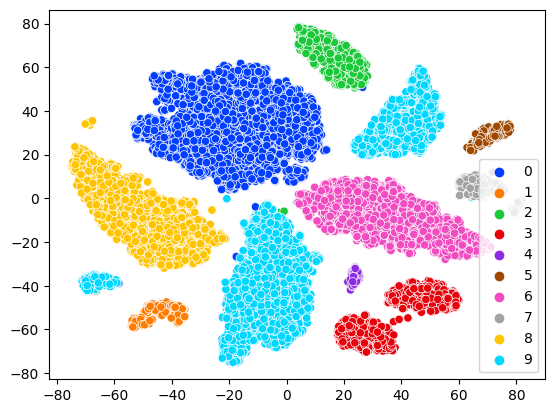

In [369]:
palette = sns.color_palette("bright", 10)
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=dsm_y, legend='full', palette=palette)
plt.show()